UNDERSTAND HOW THINGS WORK FIRST

In [ ]:
import json
import os
import random
import cv2
import gc
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from helper import gather_json, MangaBubbleDataset
from deeplabv3 import model
import torchvision.transforms as T


In [ ]:
END_WITH_LOCAL = 'DEEPLABv3'

os.environ['PATH'] = f"/root/.cargo/bin:{os.environ['PATH']}"

NOTEBOOK_DIR = os.getcwd()
print(f"NOTEBOOK_DIR: {NOTEBOOK_DIR}")

# Simple validation
if not (NOTEBOOK_DIR.endswith('/content') or NOTEBOOK_DIR.endswith(END_WITH_LOCAL)):
    raise ValueError(f"Expected to be in .../{END_WITH_LOCAL} or .../content directory, but got: {NOTEBOOK_DIR}")

BASE_DIR = os.path.join(NOTEBOOK_DIR, '..', '..', '..')
os.listdir(BASE_DIR)

In [ ]:
NUM_EPOCHS= 10
BATCH_SIZE= 8

IMAGE_DIR = os.path.join(BASE_DIR, 'data/Manga109_released_2023_12_07/images')
MASK_DIR  = os.path.join(BASE_DIR, 'data/MangaSegmentation/jsons_processed')
DEEPLABv3_DATA_DIR = os.path.join(BASE_DIR, 'data/MangaSegmentation/DEEPLABv3_data')
os.makedirs(DEEPLABv3_DATA_DIR, exist_ok=True)
TRAIN_JSON_FILE = os.path.join(DEEPLABv3_DATA_DIR, "train.json")
VAL_JSON_FILE = os.path.join(DEEPLABv3_DATA_DIR, "val.json")
DEEPLABv3_MODEL_DIR = os.path.join(BASE_DIR, 'models/bubble-detection/DEEPLABv3')
os.makedirs(DEEPLABv3_MODEL_DIR, exist_ok=True)
DEEPLABv3_MODEL_FILE = os.path.join(DEEPLABv3_MODEL_DIR, 'best_unet_model.pth')
EX_JSON_FILE= os.path.join(BASE_DIR,'data/MangaSegmentation/jsons_processed/Arisa.json')
EX_IMG_FILE= os.path.join(BASE_DIR, 'data/Manga109_released_2023_12_07/images/AisazuNihaIrarenai/029.jpg')

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

In [ ]:
print("Print keys for example processed json:")
with open (EX_JSON_FILE,'r') as f:
    data= json.load(f)

print(data.keys())

print("Examine annotations field:")
print(data['annotations'])


img_name = os.path.basename(EX_IMG_FILE)
print(img_name)

image = cv2.imread(EX_IMG_FILE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

del image

In [ ]:
# --- Lấy danh sách tất cả series ---
all_series = sorted(os.listdir(IMAGE_DIR))
random.seed(42)
random.shuffle(all_series)

split_idx = int(len(all_series) * 0.8)
train_series = all_series[:split_idx]
val_series   = all_series[split_idx:]

print(train_series)
print(val_series)

In [ ]:
# Usage với safety check
print("Starting data gathering...\n")

# Debug: print series list trước
print(f"Train series ({len(train_series)}): {train_series[:3]}..." if len(train_series) > 3 else f"Train series: {train_series}")
print(f"Val series ({len(val_series)}): {val_series[:3]}..." if len(val_series) > 3 else f"Val series: {val_series}")
print()

train_json = gather_json(train_series, keep_cat_id=5, mask_dir=MASK_DIR)

val_json = gather_json(val_series, keep_cat_id=5, mask_dir=MASK_DIR)

# Save
with open(TRAIN_JSON_FILE, "w+") as f:
    json.dump(train_json, f, indent=2)

with open(VAL_JSON_FILE, "w+") as f:
    json.dump(val_json, f, indent=2)

print("\n JSON files saved!")
print(f"   {TRAIN_JSON_FILE}")
print(f"   {VAL_JSON_FILE}")

In [ ]:
print(" Creating image lists...\n")

# Tạo train_img_list từ train_json
train_img_list = [img["file_name"] for img in train_json["images"]]
print(f"Train image list created: {len(train_img_list)} images")
print(f"   Sample (first 3): {train_img_list[:3]}")

# Tạo val_img_list từ val_json
val_img_list = [img["file_name"] for img in val_json["images"]]
print(f"Val image list created: {len(val_img_list)} images")
print(f"   Sample (first 3): {val_img_list[:3]}")

print("ALL DONE!")
print(f"   Train: {len(train_img_list)} images, {len(train_json['annotations'])} annotations")
print(f"   Val: {len(val_img_list)} images, {len(val_json['annotations'])} annotations")

del train_series, val_series, train_json, val_json


In [ ]:
data = json.load(open(TRAIN_JSON_FILE))
print("Annotations:", len(data["annotations"]))
print("Images:", len(data["images"]))
print("Unique categories:", set(a["category_id"] for a in data["annotations"]))

In [ ]:
# --- Example transforms ---
img_size = (256,256)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()])

train_set = MangaBubbleDataset(
    json_file=TRAIN_JSON_FILE,
    img_dir=IMAGE_DIR,
    img_size=img_size,
    transform=transform
)

val_set = MangaBubbleDataset(
    json_file=VAL_JSON_FILE,
    img_dir=IMAGE_DIR,
    img_size=img_size,
    transform=transform
)

batch_size = BATCH_SIZE
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Debug: Kiểm tra mapping giữa image paths và JSON data
print("Checking first 10 images in train dataset...\n")

for idx in range(min(10, len(train_set))):
    img_info = train_set.images[idx]
    img_id = img_info['id']
    img_name = img_info['file_name']  # VD: "Nekodama/001.jpg"
    
    # Tạo full path
    full_path = os.path.join(train_set.img_dir, img_name)
    
    # Kiểm tra annotation
    has_anno = img_id in train_set.annos_by_id
    num_anno = len(train_set.annos_by_id.get(img_id, []))
    
    # Kiểm tra file tồn tại
    exists = os.path.exists(full_path)
    
    print(f"[{idx}] ID: {img_id}")
    print(f"    File name: {img_name}")
    print(f"    Full path: {full_path}")
    print(f"    Has annotations: {num_anno} annos")
    print(f"    Size: {img_info['width']}x{img_info['height']}")
    print()

# Test thử load 1 sample
print("\n Testing dataset __getitem__...")
try:
    img, mask = train_set[0]
    print("Successfully loaded first sample!")
    print(f"   Image shape: {img.shape}")
    print(f"   Mask shape: {mask.shape}")
    print(f"   Mask sum: {mask.sum().item()}")
    print(f"   Mask has bubbles: {'YES' if mask.sum() > 0 else 'NO (all zeros)'}")
except Exception as e:
    print(f"Error loading sample: {e}")
    import traceback
    traceback.print_exc()

# So sánh với train_img_list (nếu bạn vẫn có)
if 'train_img_list' in locals():
    print("\n Comparing with train_img_list...")
    print(f"train_img_list length: {len(train_img_list)}")
    print(f"train_set length: {len(train_set)}")
    print(f"First 3 in train_img_list: {train_img_list[:3]}")
    print(f"First 3 in train_set: {[train_set.images[i]['file_name'] for i in range(min(3, len(train_set)))]}")

del train_img_list, val_img_list
gc.collect()

sửa tiếp từ đây

In [ ]:
model= model

if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)
criterion = nn.BCEWithLogitsLoss()  # segmentation nhị phân
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    for imgs, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgs = imgs.to(device)
        masks = masks.float().to(device)  

        optimizer.zero_grad()

        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.float().to(device)

            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)

            # convert to binary mask
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # boolean masks
            preds_bool = preds.bool()
            masks_bool = masks.bool()

            # Intersection + Union
            intersection = (preds_bool & masks_bool).sum(dim=(1,2,3)).float()
            union = (preds_bool | masks_bool).sum(dim=(1,2,3)).float()

            iou = (intersection + 1e-7) / (union + 1e-7)
            dice = (2 * intersection + 1e-7) / (
                preds_bool.sum(dim=(1,2,3)).float() +
                masks_bool.sum(dim=(1,2,3)).float() +
                1e-7
            )

            iou_scores.extend(iou.cpu().tolist())
            dice_scores.extend(dice.cpu().tolist())

    val_loss /= len(val_loader.dataset)
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)


    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_deeplabv3_model.pth")
        print("Saved Better Model")
        

Training Epoch 1: 100%|██████████| 979/979 [07:20<00:00,  2.22it/s]


Epoch 1/10 | Train Loss: 0.1049 | Val Loss: 0.0788 | IoU: 0.7659 | Dice: 0.8580
Saved Better Model


Training Epoch 2: 100%|██████████| 979/979 [07:18<00:00,  2.23it/s]


Epoch 2/10 | Train Loss: 0.0748 | Val Loss: 0.0693 | IoU: 0.7953 | Dice: 0.8768
Saved Better Model


Training Epoch 3: 100%|██████████| 979/979 [07:20<00:00,  2.22it/s]


Epoch 3/10 | Train Loss: 0.0654 | Val Loss: 0.0767 | IoU: 0.7795 | Dice: 0.8667


Training Epoch 4: 100%|██████████| 979/979 [07:18<00:00,  2.23it/s]


Epoch 4/10 | Train Loss: 0.0593 | Val Loss: 0.0674 | IoU: 0.8017 | Dice: 0.8809
Saved Better Model


Training Epoch 5: 100%|██████████| 979/979 [07:18<00:00,  2.23it/s]


Epoch 5/10 | Train Loss: 0.0548 | Val Loss: 0.0602 | IoU: 0.8169 | Dice: 0.8908
Saved Better Model


Training Epoch 6: 100%|██████████| 979/979 [07:17<00:00,  2.24it/s]


Epoch 6/10 | Train Loss: 0.0512 | Val Loss: 0.0615 | IoU: 0.8221 | Dice: 0.8943


Training Epoch 7: 100%|██████████| 979/979 [07:19<00:00,  2.23it/s]


Epoch 7/10 | Train Loss: 0.0477 | Val Loss: 0.0615 | IoU: 0.8227 | Dice: 0.8954


Training Epoch 8: 100%|██████████| 979/979 [07:20<00:00,  2.22it/s]


Epoch 8/10 | Train Loss: 0.0457 | Val Loss: 0.0609 | IoU: 0.8292 | Dice: 0.8990


Training Epoch 9: 100%|██████████| 979/979 [07:19<00:00,  2.23it/s]


Epoch 9/10 | Train Loss: 0.0433 | Val Loss: 0.0605 | IoU: 0.8269 | Dice: 0.8966


Training Epoch 10: 100%|██████████| 979/979 [07:19<00:00,  2.23it/s]


Epoch 10/10 | Train Loss: 0.0416 | Val Loss: 0.0651 | IoU: 0.8271 | Dice: 0.8973


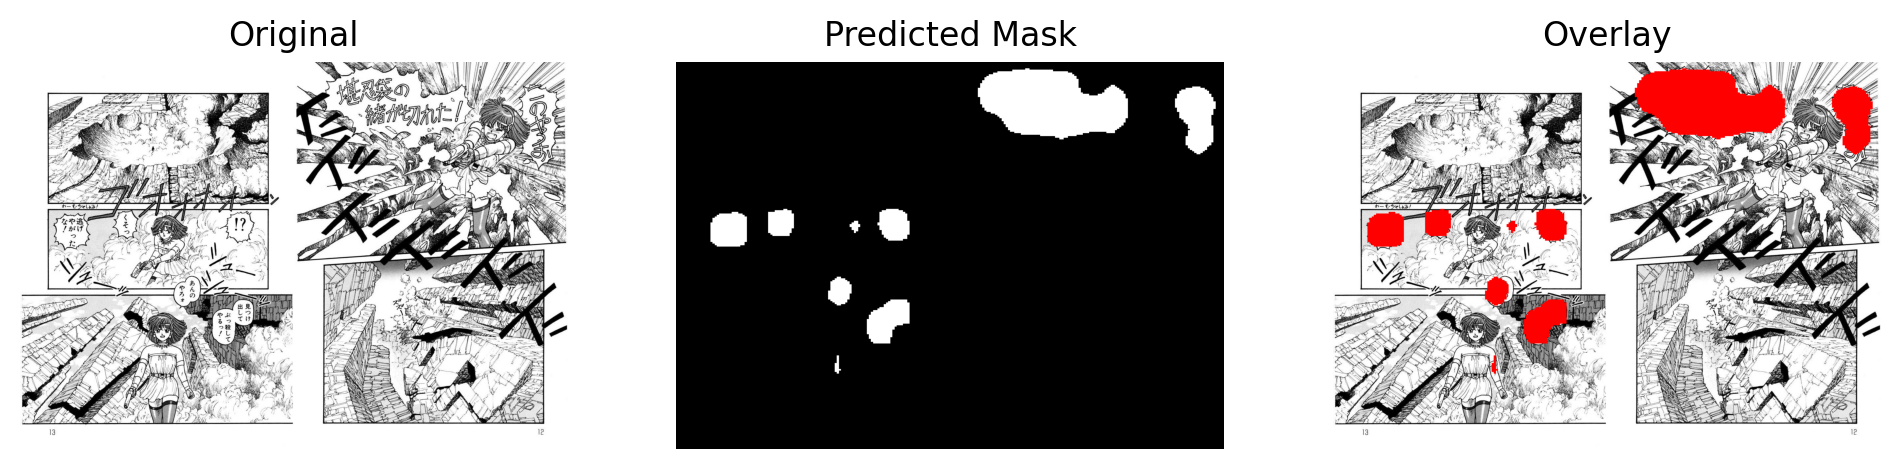

In [ ]:
state_dict = torch.load(DEEPLABv3_MODEL_FILE, 
                        map_location=torch.device(device))

if any(k.startswith("module.") for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    state_dict = new_state_dict

model.load_state_dict(state_dict, strict=False)
model.eval()

img =  cv2.imread(EX_IMG_FILE)
cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

resized = cv2.resize(img, (256, 256)) 

transform = T.Compose([
    T.ToTensor(),
])

input_tensor = transform(resized).unsqueeze(0)  # [1, C, H, W]

with torch.no_grad():
    output = model(input_tensor)  # DeepLabV3 trả dict {"out": tensor}
    pred = output['out']          # [1, 1, H, W] nếu binary
    pred = torch.sigmoid(pred)    # nếu binary segmentation
    pred = pred.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]

# threshold mask
mask = (pred > 0.5).astype(np.uint8)

# resize về kích thước ảnh gốc
mask_full = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# tạo overlay màu đỏ
overlay = img.copy()
overlay[mask_full == 1] = (255, 0, 0)

# visualize
plt.figure(figsize=(12,4), dpi=200)
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(mask_full, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.savefig("inference.png")
plt.show()

